In [6]:
from utils.plant_to_circle import convert_to_plant_colorspace
import pickle as pkl
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from utils.center_constants import TYPES_TO_COLORS
import os
np.random.seed(0)

In [4]:
def distance_from_center(center, points: np.ndarray):
    if len(points) > 1000:
        np.random.shuffle(points)
        points = points[:1000]
    return np.apply_along_axis(lambda p: np.linalg.norm(center-p, 2), 1, points)
# Test
distance_from_center(np.array([0,0]), np.array([[1,1],[2,2]]))

def percent_pixels_included(circles, plant_isolated_mask):
    '''
    Parameters:
        circles: list of circles in form [(x,y), r]
        plant_isolated_mask: plant mask
    Returns:
        coverage ratio

    Returns the portion of non-black pixels in plant_isolated_mask that are inside of a circle.
    '''
    # Turn the mask into a binary image
    plant_isolated_mask = cv2.cvtColor(plant_isolated_mask, cv2.COLOR_RGB2GRAY)
    plant_isolated_mask = plant_isolated_mask/plant_isolated_mask.max()
    # Count total number of color pixels in the image
    total_color_pixels = np.sum(plant_isolated_mask==1)
    # Mask out circles
    [cv2.circle(plant_isolated_mask, (int(circle[0][0]), int(circle[0][1])), int(circle[1]), 0, -1) for circle in circles]
    # Count the number of non-black pixels
    uncovered_color_pixels = np.sum(plant_isolated_mask==1)
    return 1-(uncovered_color_pixels/total_color_pixels)

def circle_fill_ratio(circles, plant_isolated_mask, double_count_overlap = True):
    '''
    Parameters:
        circles: list of circles in form [(x,y), r]
        plant_isolated_mask: plant mask
    Returns:
        average fill ratio

    Returns the average fill ratio of the circles in plant_isolated_mask.
    '''
    # Turn the mask into a binary image
    plant_isolated_mask = cv2.cvtColor(plant_isolated_mask, cv2.COLOR_RGB2GRAY)
    plant_isolated_mask = plant_isolated_mask/plant_isolated_mask.max()
    # Count total number of pixels in the image
    total_color_pixels_pre_mask = np.sum(plant_isolated_mask==1)
    # Mask out circles
    [cv2.circle(plant_isolated_mask, (int(circle[0][0]), int(circle[0][1])), int(circle[1]), 0, -1) for circle in circles]
    # Count the number of non-black pixels after masking
    total_color_pixels_post_mask = np.sum(plant_isolated_mask==1)
    # Calculate the area of the circles
    if double_count_overlap:
        total_circle_area = np.sum([circle[1]**2*np.pi for circle in circles])
    else:
        # Make a white image the same size as the mask
        plant_isolated_mask_copy = np.ones(plant_isolated_mask.shape)
        # Mask out circles
        [cv2.circle(plant_isolated_mask_copy, (int(circle[0][0]), int(circle[0][1])), int(circle[1]), 0, -1) for circle in circles]
        # Count the number of non-black pixels after masking
        total_circle_area = np.sum(plant_isolated_mask_copy==0)
    # Calculate the number of color pixels inside of the circles
    covered_pixel_area = total_color_pixels_pre_mask - total_color_pixels_post_mask
    # return the  fill ratio
    return covered_pixel_area/total_circle_area if total_circle_area != 0 else 1

# bgr_img = cv2.imread("./out/post_process/snc-21081208141400.png")
# img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
# kale_isolated, _ = convert_to_plant_colorspace(None, img, img, "kale")
# plt.imshow(kale_isolated)
# circles = [(374.9313109281532, np.array([2385.2766756 ,  450.89383378])), (263.94026566502777, np.array([903.493762  , 329.52015355])), (312.18062353933004, np.array([3071.30097357,  889.62586926])), (275.1610969585484, np.array([316.42630293, 961.84934853]))]
# percent_pixels_included(circles, kale_isolated), circle_fill_ratio(circles, kale_isolated)

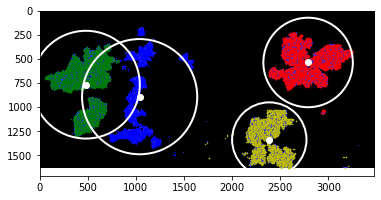

Percent Coverage From Circles:  0.9823484123579811
Average Fill Ratio of Circles:  0.3223164056903671


In [7]:
bgr_img = cv2.imread("./out/post_process/snc-21081208141400.png")
img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
kale_isolated, _ = convert_to_plant_colorspace(None, img, img, "kale")
mask = np.logical_or.reduce((kale_isolated[:,:,0]>50,kale_isolated[:,:,1]>50,kale_isolated[:,:,2]>50))
point_clouds = np.array(np.where(mask)).T # returns all pixels satisfying these conditions
km = KMeans(4)
np.random.shuffle(point_clouds)
point_clouds = point_clouds[:10000]
km.fit(point_clouds)
fig, ax = plt.subplots()
ax.imshow(kale_isolated)
ax.plot(*zip(*km.cluster_centers_[:,::-1]), marker='o', color='w', ls='')
colors = ['r', 'g', 'b', 'y', 'c']
circles = []
for i in np.arange(4):
    filtered_points = point_clouds[km.labels_ == i]
    center = km.cluster_centers_[i][::-1]
    np.random.shuffle(filtered_points)
    filtered_points = filtered_points[:10000]
    # r = distance_from_center(center, filtered_points).std()*1.96
    # distance_from_center(center, filtered_points)
    distance_transformed = distance_from_center(center, filtered_points)
    r_std = distance_transformed.std()*2.576
    # r_percentile = np.percentile(distance_transformed, 90)
    # data_cov = np.cov(filtered_points.T)
    r = r_std
    ax.add_artist(plt.Circle(center, r, fill=False, lw=2, color="w"))
    plt.scatter(*zip(*[item[::-1] for item in filtered_points]), marker='.', color=colors[i], s=1)
    circles.append((center, r))
plt.show()

print("Percent Coverage From Circles: ", percent_pixels_included(circles, kale_isolated))
print("Average Fill Ratio of Circles: ", circle_fill_ratio(circles, kale_isolated, double_count_overlap=False))

Fitting borage
Fitting cilantro
Fitting green-lettuce
Fitting kale
Fitting radicchio
Fitting red-lettuce
Fitting swiss-chard
Fitting turnip


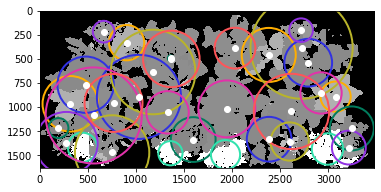

In [ ]:
bgr_img = cv2.imread("./out/post_process/snc-21081208141400.png")
img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
centers, radii, colors = [], [], []
for plant in TYPES_TO_COLORS.keys():
    if plant == "other":
        continue
    kale_isolated, _ = convert_to_plant_colorspace(None, img, img, plant)
    mask = np.logical_or.reduce((kale_isolated[:,:,0]>50,kale_isolated[:,:,1]>50,kale_isolated[:,:,2]>50))
    point_clouds = np.array(np.where(mask)).T # returns all pixels satisfying these conditions
    km = KMeans(4)
    np.random.shuffle(point_clouds)
    point_clouds = point_clouds[:10000]
    print("Fitting", plant)
    km.fit(point_clouds)
    for i in np.arange(4):
        center = km.cluster_centers_[i]
        filtered_points = point_clouds[km.labels_ == i]
        distance_transformed = distance_from_center(center, filtered_points)
        radii.append(distance_transformed.std()*2.576)
        centers.append(center)
        colors.append(np.array(TYPES_TO_COLORS[plant])/255)

centers = np.array(centers)
fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(bgr_img, cv2.COLOR_RGB2GRAY), cmap="gray")
ax.plot(*zip(*centers[:,::-1]), marker='o', color='w', ls='')
for c, r, col in zip(centers[:,::-1], radii, colors):
    ax.add_artist(plt.Circle(c, r, fill=False, lw=2, color=col))
plt.show()

In [42]:
def calculate_garden_benchmarks(img_path: str, circles: dict, double_count_overlap=True, show_plots=False, verbose=False):
    '''
    Params:
        img: Garden Segmask
        circles: dictionary of circles of this structure 
            {
                plant_type": [
                    (x, y), r
                    ...
                ]
            }
    Returns:
        dictionary of garden benchmarks of the form
        {
            plant_type": [
                percent_pixels_included,
                average_fill_ratio
            ]
        }
    '''
    bgr_img = cv2.imread(img_path)
    img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    garden_benchmarks = {}
    for plant_type, circle_list in circles.items():
        color_isolated_mask, _ = convert_to_plant_colorspace(None, img, img, plant_type)
        if verbose:
            print("Calculating Garden Benchmarks for", plant_type)
        c_list = []
        if show_plots:
            _, ax = plt.subplots()
            ax.imshow(color_isolated_mask)
            for c_dict in circle_list:
                c, r = c_dict["circle"][:2]
                c_list.append((c, r))
                ax.add_artist(plt.Circle(c, r, fill=False, lw=2, color="w"))
            plt.show()
        garden_benchmarks[plant_type] = [
                percent_pixels_included(c_list, color_isolated_mask), 
                circle_fill_ratio(c_list, color_isolated_mask, double_count_overlap=double_count_overlap)
            ]
    return garden_benchmarks

def kmean_circle(img_path, verbose=False):
    bgr_img = cv2.imread(img_path)
    img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    circles = {}
    for plant in TYPES_TO_COLORS.keys():
        if plant == "other":
            continue
        circles[plant] = []
        kale_isolated, _ = convert_to_plant_colorspace(None, img, img, plant)
        mask = np.logical_or.reduce((kale_isolated[:,:,0]>50,kale_isolated[:,:,1]>50,kale_isolated[:,:,2]>50))
        point_clouds = np.array(np.where(mask)).T # returns all pixels satisfying these conditions
        km = KMeans(4)
        np.random.shuffle(point_clouds)
        point_clouds = point_clouds[:10000]
        if verbose:
            print("Fitting", plant)
        km.fit(point_clouds)
        for i in np.arange(4):
            center = km.cluster_centers_[i][::-1]
            filtered_points = point_clouds[km.labels_ == i]
            distance_transformed = distance_from_center(center, filtered_points)
            r = distance_transformed.std()*2.576
            circles[plant].append({"circle": (center, r)})
    return circles
    

In [43]:
import re
date_re_mask = r"snc-(\d{6})"
date_re_prior = r"priors(\d{6})"
mask_path = "./out/post_process/"
left_path = "./out/priors/left/"
right_path = "./out/priors/right/"
masks = [mask_path + f for f in sorted(os.listdir(mask_path))]
left_priors = [left_path + f for f in sorted(os.listdir(left_path))]
right_priors = [right_path + f for f in sorted(os.listdir(right_path))]
# Get and clean data
new_masks = []
cur_date = [""]
for m in masks:
    date = re.findall(date_re_mask, m)
    if date != cur_date:
        cur_date = date
        new_masks.append(m)
for path, left, right in zip(new_masks, left_priors, right_priors):
    date_mask = re.findall(date_re_mask, path)
    date_prior = re.findall(date_re_prior, left)
    if date_mask != date_prior:
        print("Dates don't match")
        print(date_mask, date_prior)

In [ ]:
path = "./out/post_process/snc-21071808141400.png"
left_prior = "./out/priors/left/priors210718.p"
right_prior = "./out/priors/right/priors210718.p"
k_means_data = []
bfs_data = []
for path, left, right in zip(new_masks, left_priors, right_priors):
    circles = kmean_circle(path)   
    k_means_data.append(calculate_garden_benchmarks(path, circles, double_count_overlap=True, show_plots=False))
    with open(left, 'rb') as f:
        left_prior = pkl.load(f)
    with open(right, 'rb') as f:
        right_prior = pkl.load(f)
    bfs_circles = {key: right_prior[key]+left_prior[key] for key in circles.keys()}
    bfs_data.append(calculate_garden_benchmarks(path, bfs_circles, double_count_overlap=True, show_plots=False))

In [ ]:
from multiprocessing import Pool
workers = os.cpu_count()

# Retrieve a single page and report the URL and contents
def garden_benchmarks(mask_path, left_prior, right_prior):
    try:
        circles = kmean_circle(mask_path)
        with open(left_prior, 'rb') as f:
            left_prior = pkl.load(f)
        with open(right_prior, 'rb') as f:
            right_prior = pkl.load(f)
        bfs_circles = {key: right_prior[key]+left_prior[key] for key in circles.keys()}
        return calculate_garden_benchmarks(path, circles, double_count_overlap=True, show_plots=False), calculate_garden_benchmarks(mask_path, bfs_circles, double_count_overlap=True, show_plots=False)
    except Exception as e:
        print("Failed to process", mask_path)

def wrapper(args):
    return garden_benchmarks(*args)

paths = list(zip(new_masks, left_priors, right_priors))
with Pool(workers) as p:
    results = p.map(wrapper, paths)
results

In [63]:
def sq(x, y):
    return x*x + y*y

def wrapper(args):
    return sq(*args)

with Pool(workers) as p:
    results = p.map(wrapper, [(1, 2), (3, 4), (5, 6), (7, 8)])
results

[5, 25, 61, 113]

In [67]:
garden_benchmarks(*paths[25])

/home/users/sandeepmukh/AlphaGarden/agenv/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/users/sandeepmukh/AlphaGarden/agenv/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars
/home/users/sandeepmukh/AlphaGarden/agenv/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


({'borage': [0.0, 1],
  'cilantro': [0.0, 1],
  'green-lettuce': [nan, 1],
  'kale': [0.0, 1],
  'radicchio': [0.0, 1],
  'red-lettuce': [0.0, 1],
  'swiss-chard': [0.0, 1],
  'turnip': [0.0, 1]},
 {'borage': [0.0, 1],
  'cilantro': [0.0, 1],
  'green-lettuce': [0.0, 1],
  'kale': [0.0, 1],
  'radicchio': [0.0, 1],
  'red-lettuce': [0.0, 1],
  'swiss-chard': [0.0, 1],
  'turnip': [0.0, 1]})

In [94]:
# Logistic regression update rule via newtons method
from scipy.special import expit
from sklearn.metrics import log_loss
w_init = np.array([-1, 1, 0]).T
X = np.array([[.2,3.1,1], [1.0, 3.0,1], [-.2,1.2,1], [1.0, 1.1,1]])
y = np.array([1,1,0,0])
def logifunc(X, w):
    return expit(np.dot(X, w))

def update_rule(X, y, w):
    hessian = X.T.dot(np.diag(logifunc(X, w)*(1-logifunc(X, w)))).dot(X)
    return w - np.linalg.inv(hessian).dot(np.dot(X.T, (logifunc(X, w) - y)))

print("loss", log_loss(y, logifunc(X, w_init)))
print("s0", logifunc(X, w_init))
w = update_rule(X, y, w_init)
print("w1:", w)
print("s1:", logifunc(X, w))
print("loss", log_loss(y, logifunc(X, w)))
w = update_rule(X, y, w)
print("w2:", w)
print("s2:", logifunc(X, w))
print("loss", log_loss(y, logifunc(X, w)))

loss 0.6363262143132393
s0 [0.94784644 0.88079708 0.80218389 0.52497919]
w1: [ 1.32465198  3.04991697 -6.82910388]
s1: [0.94737826 0.97455097 0.03124556 0.10437391]
loss 0.055452919703877376
w2: [ 1.36602464  4.15753654 -9.19961627]
s2: [0.98132929 0.99042537 0.01116463 0.03695848]
loss 0.019338535044462733
